This notebook takes processed mat/pickle files and makes a dataset for prediction.
In particular, given a history and prediction horizon, this generates all viable slices of a full trajectory.

In [1]:
import glob
import numpy as np
import scipy.io as sio
import pickle
import matplotlib.pyplot as plt
import pdb

### TODO
* [x] interpolating heading (see interpolate_heading). Added a `np.unwrap()` to prevent possible wrapping around issue
* [x] switch to ego frame (position/orientation are all zero at t = 0). Added a switch in `get_ego_trajectory_prediction_snippets()` function.
* [x] optional: complete outlier removal in bag_processing (see "Additional Notes")
* [ ] VG: If collided, return None and continue the BIG for loop.
* any ideas for dataset quality checking?

### Data Loading

In [2]:
save_ext = 'pkl'
files_to_process = glob.glob('../examples/bags/*.%s' % save_ext)

print('Found %d files to read: %s' % (len(files_to_process), files_to_process))

Found 4 files to read: ['../examples/bags/parking_p1_t1_e0_2019-11-04-14-34-23.pkl', '../examples/bags/parking_p2_t1_e2_2019-11-04-16-33-34.pkl', '../examples/bags/parking_p2_t1_e4_2019-11-04-16-34-11.pkl', '../examples/bags/parking_p2_t2_e0_2019-11-04-16-36-50.pkl']


In [3]:
file_num = 3 # TODO: starting with the first matfile for now
if save_ext == 'mat':
    res_dict = sio.loadmat(files_to_process[file_num], matlab_compatible=True) 
    
elif save_ext == 'pkl':
    res_dict = pickle.load(open(files_to_process[file_num],'rb'))
else:
    raise NotImplemented("Invalid extension.")

In [4]:
# Function to get all possible goals, along with occupancy.
def extract_goals(res_dict):
    # Extract goal options
    occupied_spots = []
    for static_vehicle in res_dict['vehicle_object_lists'][0]:
        xv = round(static_vehicle['position'][0], 2)
        yv = round(static_vehicle['position'][1], 2)
        occupied_spots.append([xv, yv, 1])
    occupied_spots = np.array(occupied_spots)

    goals = []
    xg = sorted(set(occupied_spots[:,0]))
    yg = sorted(set(occupied_spots[:,1]))
    for idx, x in enumerate(xg):
        for y in yg:
            if idx == 0 or idx == len(xg) - 1:
                continue
            diffs = np.sum(np.square( occupied_spots[:,:2] - np.array([x,y]) ), axis= 1)
            if np.min(diffs) < 1e-6:
                goals.append([x,y,0])
            else:
                goals.append([x,y,1])
    goals = np.array(goals)
    
    return goals

In [5]:
def extract_control_info(res_dict):
    ts = [];
    speeds = [];
    accs = [];
    oris = [];
    throttles = []; steers = []; brakes = []
    hand_brakes = []; reverses = []; gears = [];
    manual_gear_shifts = []
    
    for entry in res_dict['ego_control_list']:
        ts.append(entry['time'])
        speeds.append(entry['velocity'])
        accs.append(entry['acceleration'])
        oris.append(entry['orientation'])
        throttles.append(entry['throttle'])
        steers.append(entry['steer'])
        brakes.append(entry['brake'])
        hand_brakes.append(entry['hand_brake'])
        reverses.append(entry['reverse'])
        gears.append(entry['gear'])
        manual_gear_shifts.append(entry['manual_gear_shift'])
    
    ego_control_dict = {}
    ego_control_dict['t'] = np.array(ts)
    ego_control_dict['speed'] = np.array(speeds)
    ego_control_dict['acceleration'] = np.array(accs)
    ego_control_dict['orientation'] = np.array(oris)
    ego_control_dict['throttle'] = np.array(throttles)
    ego_control_dict['steer'] = np.array(steers)
    ego_control_dict['brake'] = np.array(brakes)
    ego_control_dict['gear'] = np.array(gears)
    ego_control_dict['hand_brakes'] = np.array(hand_brakes).astype(np.int)
    ego_control_dict['reverse'] = np.array(reverses).astype(np.int)
    ego_control_dict['manual_gear_shift'] = np.array(manual_gear_shifts).astype(np.int)
    
    return ego_control_dict

In [6]:
def get_longitudinal_velocity(time, vx, vy, v_prev, ego_control_dict):
    speed = np.sqrt(vx**2 + vy**2)
    gear_ind = np.argmax(time <= ego_control_dict['t'] )
    vsign_from_gear = -1.0 if ego_control_dict['reverse'][gear_ind] > 0 else 1.0
    vel_from_gear = vsign_from_gear * speed
        
    if speed < 0.05 or v_prev is None or vsign_from_gear == np.sign(v_prev):
        return vel_from_gear # vel signs match up or no history to go off of.
    else:
        # Outlier detection - possible to have forward speed in reverse and vice-versa.
        vdiff_opp_gear = np.abs(-vel_from_gear - v_prev)
        vdiff_with_gear = np.abs(vel_from_gear - v_prev)
         
        if vdiff_opp_gear < vdiff_with_gear:
            return -vel_from_gear
        else:
            return vel_from_gear

In [7]:
# Function to get full state and intent (goal index) trajectory for a single demonstration.
def extract_full_trajectory(res_dict, goals, prune_start=True, prune_end=True, min_vel_thresh=0.01):
    '''
    prune_start: if True, remove non-moving portion of data at the start
    prune_end:   if True, remove non-moving portion of data at the end
    min_vel_thresh: minimum velocity (m/s) above which vehicle is moving
    TODO: handle collisions + bad data somehow, maybe return []
    '''
    # Extract intention signal time
    # TODO: what to do if the intention list has multiple entries.
    #assert( len(res_dict['intention_time_list']) == 1 ) 
    intention_time = res_dict['intention_time_list'][0]

    # See if there were any collisions.
    # TODO: what to do if any collisions. Maybe return empty?
    if len(res_dict['ego_collision_list']) > 0:
        print('Collisions encountered: ')

        for entry in res_dict['ego_collision_list']:
            for k,v in entry.items():
                if k == 'other_id':
                    veh_name = res_dict['vehicle_dict'][v]
                    print(k,v, veh_name)
                else:
                    print(k,v)
            print('\n')
        print('\n')
#         TODO: In the BIG for loop
#         return None, None, None, None, None
    
    # Get reverse gear information to aid with speed sign.
    ego_control_dict =  extract_control_info(res_dict)
    
    # Extract ego's odometry and do goal association.
    ego_time = []
    ego_x       = [] # x coordinate in map frame (m)
    ego_y       = [] # y coordinate in map frame (m)
    ego_heading = [] # heading angle in map frame (rad)
    ego_v       = [] # estimated longitudinal velocity (m/s)
    ego_yawrate = [] # estimated angular velocity of vehicle frame wrt map frame (rad/s)

    for i, entry in enumerate(res_dict['ego_odometry_list']):
        time = entry['time']
        position = entry['position']

        ego_time.append(time)
        ego_x.append(position[0])
        ego_y.append(position[1])
        
        ehead = entry['orientation'][0]
        vx = entry['linear_velocity'][0]
        vy = entry['linear_velocity'][1]
        # This is super noisy...
        #vhead = np.arctan2(vy,vx) 
        #ehead_vec = np.array([np.cos(ehead), np.sin(ehead)])
        #vhead_vec = np.array([np.cos(vhead), np.sin(vhead)])
        #vel_sign = np.sign( np.dot(ehead_vec, vhead_vec) )
        
        if len(ego_v) > 0:
            v_long = get_longitudinal_velocity(time, vx, vy, ego_v[-1], ego_control_dict)
        else:
            v_long = get_longitudinal_velocity(time, vx, vy, None, ego_control_dict)
        
        ego_heading.append(ehead)
        ego_v.append( v_long )
        ego_yawrate.append(entry['angular_velocity'][2])
        # TODO: Could add ego_ctrl_hist for acceleration, although it's noisy. 

    inds_moving = [ n for n,ev in enumerate(ego_v) if np.abs(ev) > min_vel_thresh]
    start_ind = inds_moving[0] if prune_start else 0
    end_ind = inds_moving[-1] if prune_end else len(ego_time)-1

    # Goal selection
    final_position = np.array([ ego_x[end_ind], ego_y[end_ind] ])
    goal_ind = np.argmin( np.sum(np.square(goals[:,:2] - final_position), axis=1) )

    ego_intent = [-1 if t < intention_time else goal_ind for t in ego_time]
    switch_ind = [n for n,intent in enumerate(ego_intent) if intent > -1][0]
    ego_trajectory = np.column_stack((ego_time, ego_x, ego_y, ego_heading, ego_v, ego_yawrate, ego_intent))
    
    return ego_trajectory, start_ind, switch_ind, end_ind, goal_ind

In [8]:
goals = extract_goals(res_dict)
ego_trajectory, start_ind, switch_ind, end_ind, goal_ind = extract_full_trajectory(res_dict, goals)


Collisions encountered: 
time 1218.723575582
other_id 868 vehicle.ford.mustang_autopilot
normal_impulse [-301.71484375, -1832.911865234375, 34.343990325927734]


time 1218.823575587
other_id 868 vehicle.ford.mustang_autopilot
normal_impulse [-42.54573059082031, -468.8822937011719, 8.161503791809082]






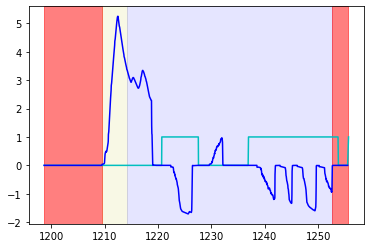

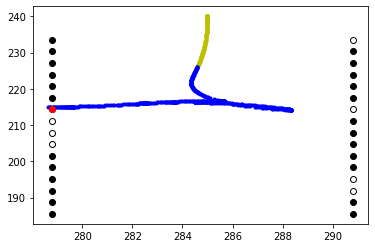

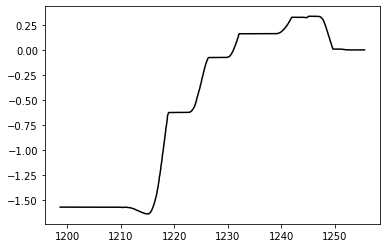

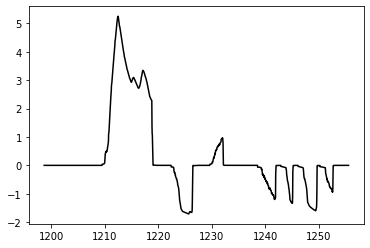

In [17]:
ego_control_dict =  extract_control_info(res_dict)

plt.figure()
plt.plot(ego_control_dict['t'], ego_control_dict['reverse'], 'c')
plt.plot(ego_trajectory[:,0], ego_trajectory[:,4], 'b')
plt.axvspan(ego_trajectory[0,0], ego_trajectory[start_ind,0], alpha=0.5, color='r')
plt.axvspan(ego_trajectory[start_ind,0], ego_trajectory[switch_ind,0], alpha=0.1, color='y')
plt.axvspan(ego_trajectory[switch_ind,0], ego_trajectory[end_ind,0], alpha=0.1, color='b')
plt.axvspan(ego_trajectory[end_ind,0], ego_trajectory[-1,0], alpha=0.5, color='r')

plt.figure()
plt.plot(ego_trajectory[start_ind:switch_ind,1], \
         ego_trajectory[start_ind:switch_ind,2], \
         'y.')
plt.plot(ego_trajectory[switch_ind:end_ind,1], \
         ego_trajectory[switch_ind:end_ind,2], \
         'b.')
for goal in goals:
    if goal[2] > 0:
        plt.plot(goal[0], goal[1], 'ko', fillstyle='none')
    else:
        plt.plot(goal[0], goal[1], 'ko')
        
plt.plot(goals[goal_ind,0], goals[goal_ind,1], 'ro')

plt.figure()
plt.plot(ego_trajectory[:,0], ego_trajectory[:,3], 'k')

plt.figure()
plt.plot(ego_trajectory[:,0], ego_trajectory[:,4], 'k')

# print(ego_trajectory[:,3])

In [14]:
def interpolate_heading(t_interp, t_ref, psi_ref):
    raise NotImplementedError("TODO") 

def interpolate_ego_trajectory(ego_trajectory, t_interp, switch_ind, include_intent = False):
    x_interp = np.interp(t_interp, ego_trajectory[:,0], ego_trajectory[:,1])
    y_interp = np.interp(t_interp, ego_trajectory[:,0], ego_trajectory[:,2]) 
    heading_interp = np.interp(t_interp, ego_trajectory[:,0], ego_trajectory[:,3]) # TODO:wraparound issue
    v_interp = np.interp(t_interp, ego_trajectory[:,0], ego_trajectory[:,4])
    yawrate_interp = np.interp(t_interp, ego_trajectory[:,0], ego_trajectory[:,5])
    
    if include_intent:
        if np.max(t_interp) >= ego_trajectory[switch_ind,0]:
            intent = ego_trajectory[switch_ind, 6] * np.ones(x_interp.shape)
        else:
            intent = -1 * np.ones(x_interp.shape)
            
        return np.column_stack((x_interp, y_interp, heading_interp, v_interp, yawrate_interp, intent))
    else:
        return np.column_stack((x_interp, y_interp, heading_interp, v_interp, yawrate_interp))
    
def get_ego_trajectory_prediction_snippets(ego_trajectory, start_ind, switch_ind, end_ind, goal_ind, goals,\
                                           Nhist=5, Npred=20, Nskip=5, dt=0.1, ego_frame=False):
    features = []; labels = []; goal_snpts = []
    
    t_range_start = ego_trajectory[start_ind, 0] + Nhist * dt
    t_range_end   = ego_trajectory[end_ind, 0] - Npred * dt
    t_skip = Nskip * dt
    print(np.array(goals).shape)
    
    for t_snippet in np.arange(t_range_start, t_range_end + 0.5 * t_skip, t_skip):
        t_hist = [x*dt + t_snippet for x in range(-Nhist + 1, 1)] # -N_hist + 1, ... , 0 -> N_hist steps
        t_pred = [x*dt + t_snippet for x in range(1, Npred+1)] # 1, ..., N_pred -> N_pred steps
    
        feature = interpolate_ego_trajectory(ego_trajectory, t_hist, switch_ind, include_intent=False)
        label   = interpolate_ego_trajectory(ego_trajectory, t_pred, switch_ind, include_intent=True)
        features.append(feature)
        labels.append(label)
        goal_snpts.append(goals.copy())
        
    print(np.array(goal_snpts).shape)
    goal_snpts = np.array(goal_snpts)
#     Transform all snippets into ego frame, if ego_frame=True
    if ego_frame:
        for id_snpt in range(len(features)):
            current = features[id_snpt][-1, :].copy()
            for id_f in range(Nhist):
                features[id_snpt][id_f, :3] -= current[0:3]
                
            for id_l in range(Npred):
                labels[id_snpt][id_l, :3] -= current[0:3]
            
            for id_g in range(len(goals)):
                goal_snpts[id_snpt][id_g, 0:2] -= current[0:2]
                
    return features, labels, goal_snpts

(32, 3)
(82, 32, 3)
Feature Example
 [[-6.104e-05  2.383e-02  5.393e-04  3.993e-02 -3.376e-04]
 [-6.104e-05  2.118e-02  5.324e-04  4.318e-02 -3.492e-04]
 [-6.104e-05  1.671e-02  5.194e-04  4.922e-02 -4.221e-04]
 [-6.104e-05  1.134e-02  5.023e-04  6.248e-02 -4.878e-04]
 [ 0.000e+00  0.000e+00  0.000e+00  2.127e-01 -1.401e-02]]
Label Example
 [[ 6.104e-05 -3.601e-02 -1.406e-03  4.227e-01 -1.436e-02 -1.000e+00]
 [-3.357e-04 -9.953e-02 -2.218e-03  4.903e-01  9.151e-04 -1.000e+00]
 [-4.272e-04 -1.300e-01 -2.590e-03  4.662e-01 -1.771e-02 -1.000e+00]
 [-1.007e-03 -1.800e-01 -2.225e-03  5.009e-01  2.558e-02 -1.000e+00]
 [-1.801e-03 -2.368e-01 -9.413e-04  6.190e-01  1.448e-02 -1.000e+00]
 [-2.441e-03 -3.042e-01  2.463e-05  7.135e-01  3.370e-03 -1.000e+00]
 [-3.021e-03 -4.271e-01  2.305e-04  1.093e+00 -2.492e-03 -1.000e+00]
 [-3.265e-03 -5.087e-01 -6.751e-05  1.310e+00 -3.958e-03 -1.000e+00]
 [-3.784e-03 -6.602e-01 -4.127e-04  1.657e+00 -2.711e-03 -1.000e+00]
 [-4.547e-03 -8.482e-01 -8.260e-04  

/home/xushen/anaconda3/envs/carla_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


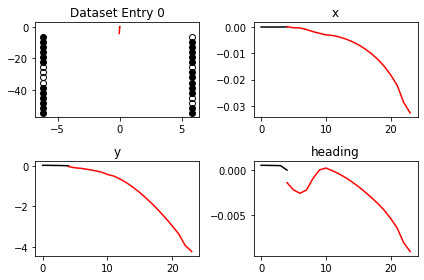

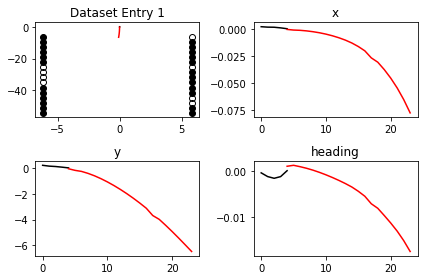

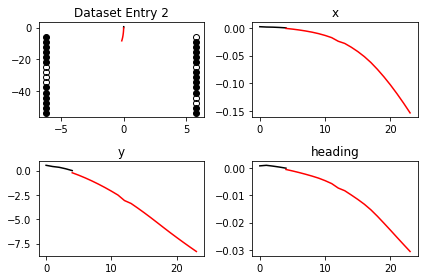

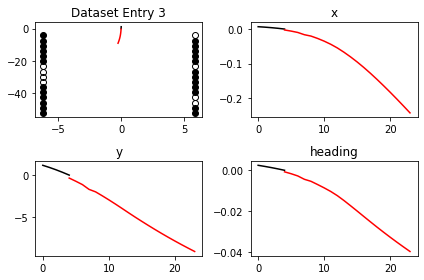

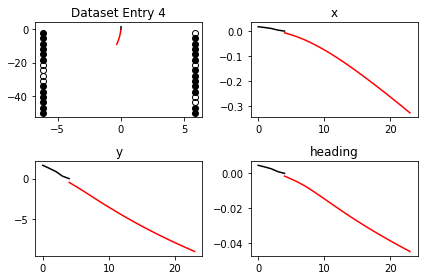

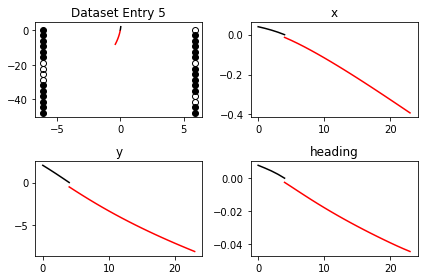

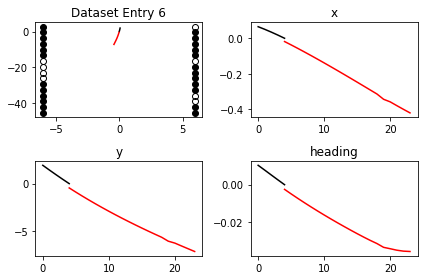

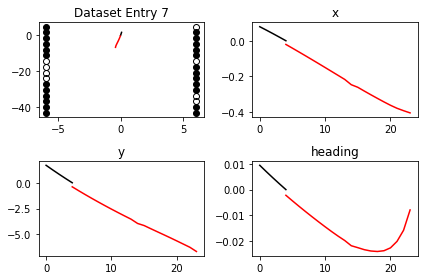

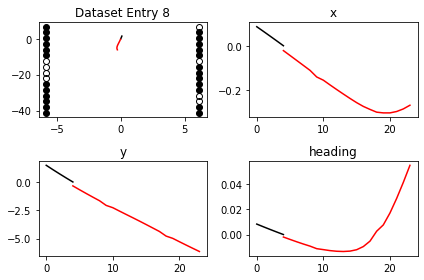

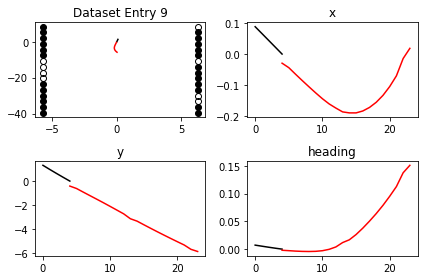

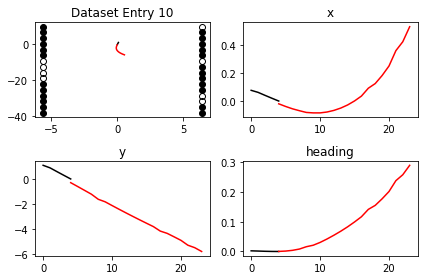

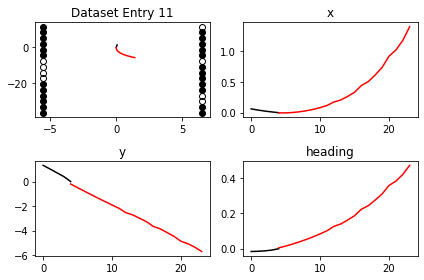

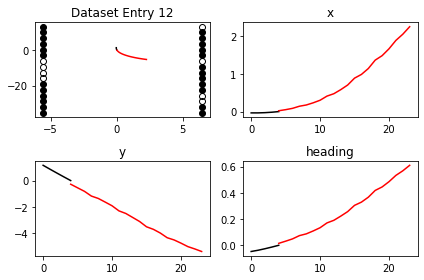

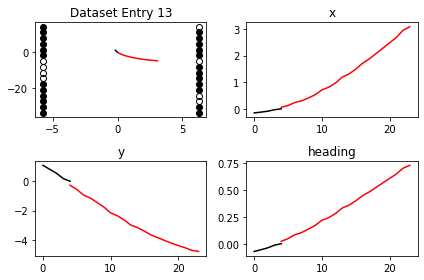

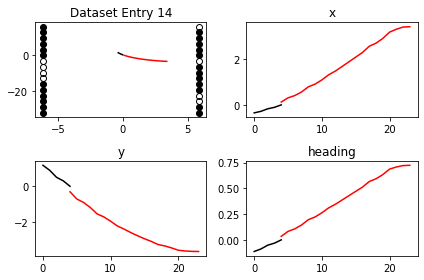

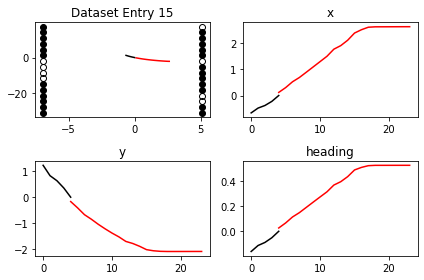

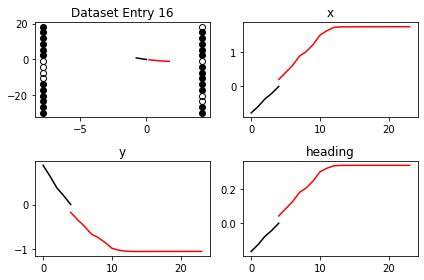

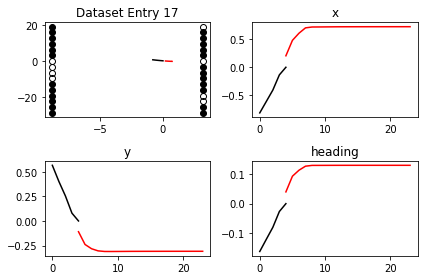

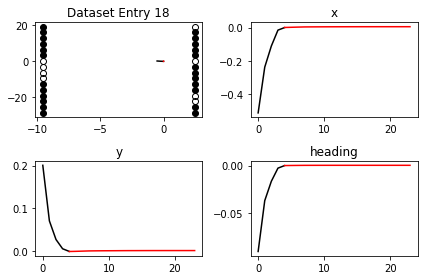

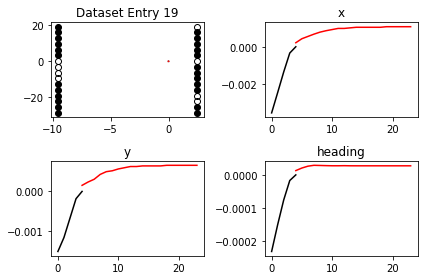

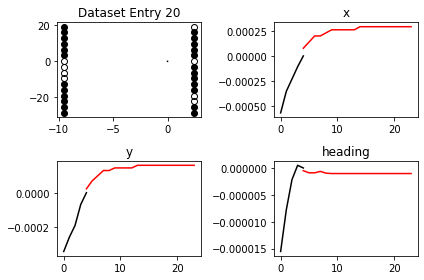

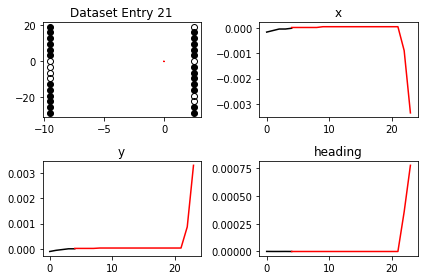

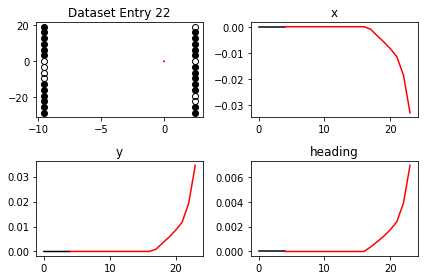

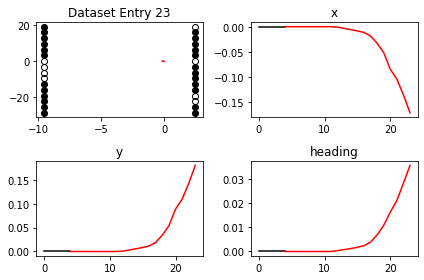

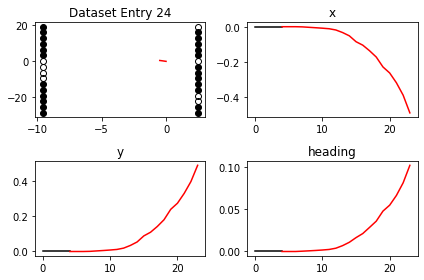

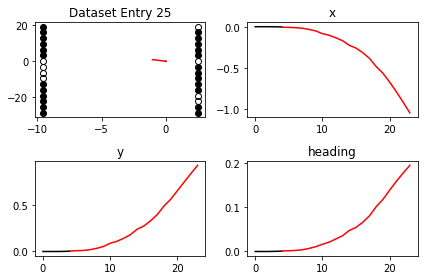

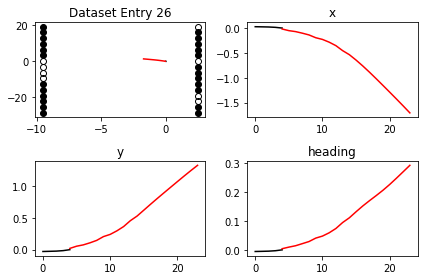

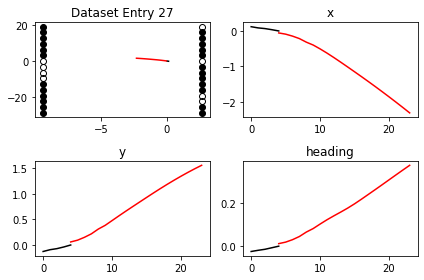

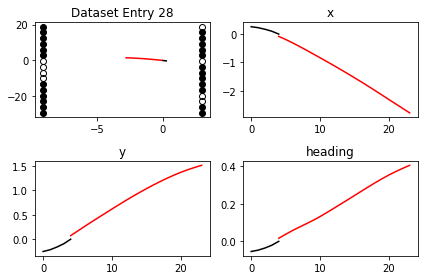

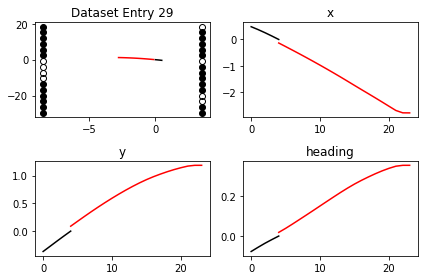

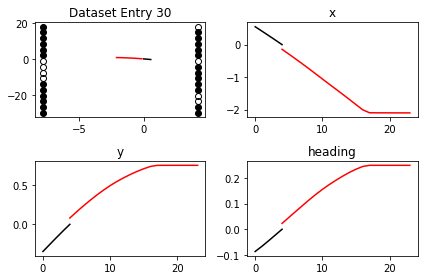

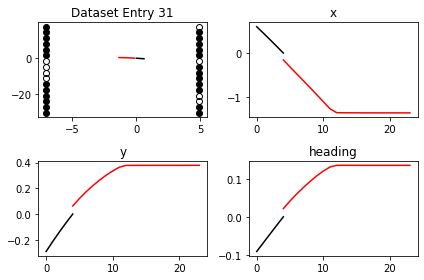

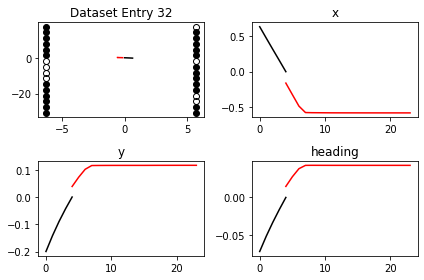

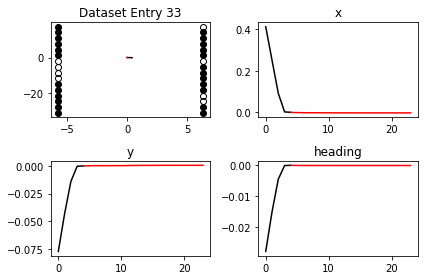

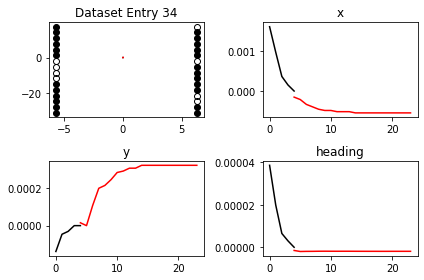

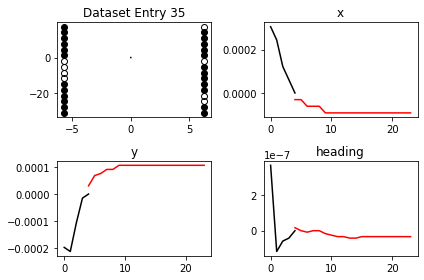

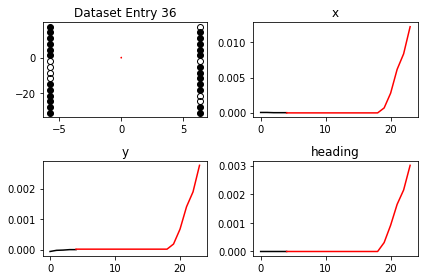

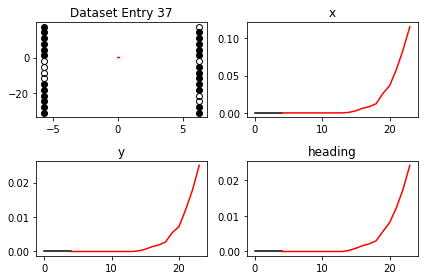

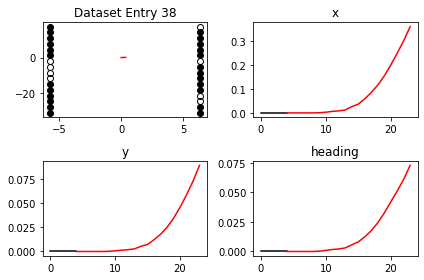

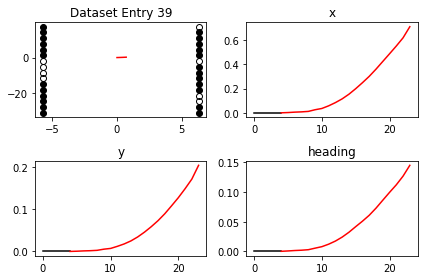

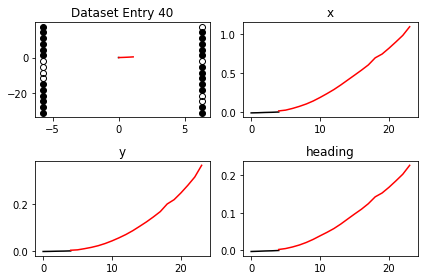

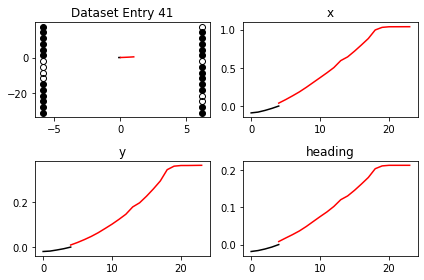

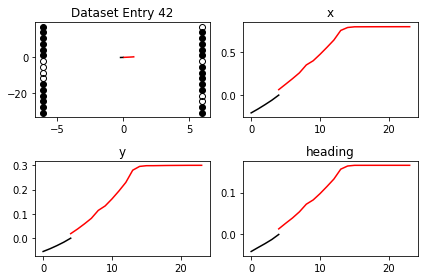

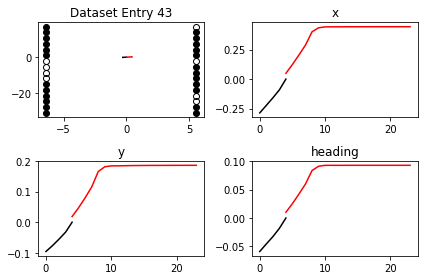

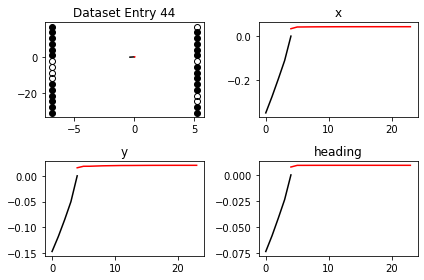

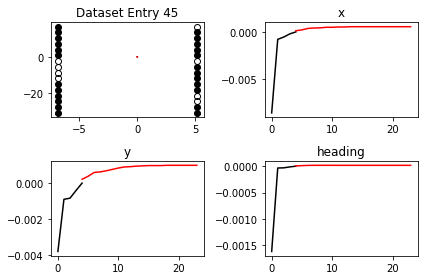

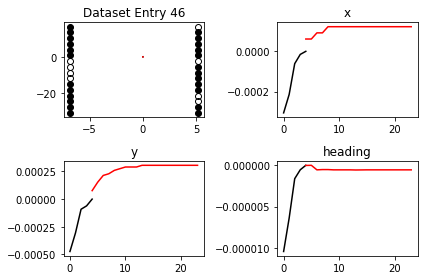

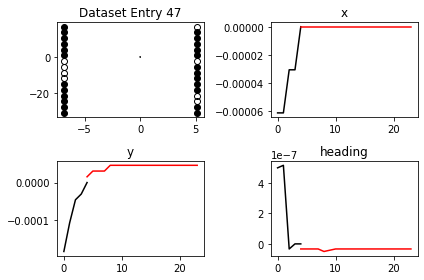

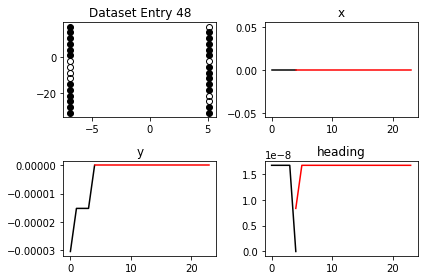

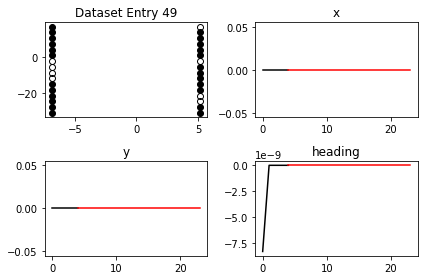

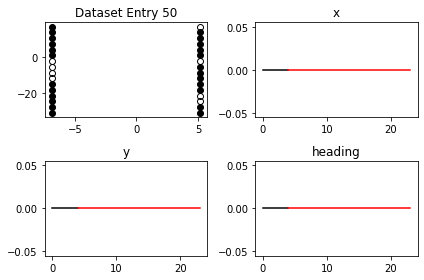

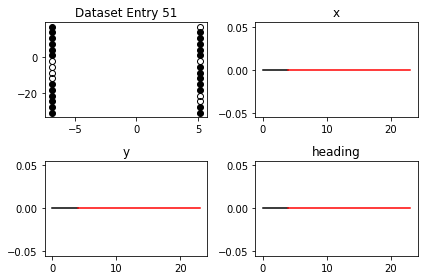

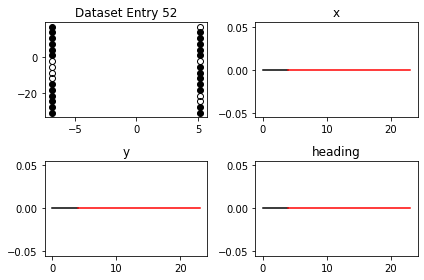

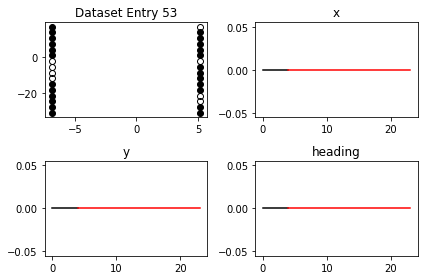

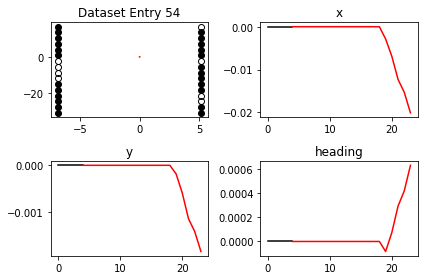

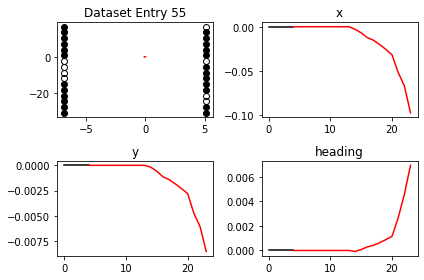

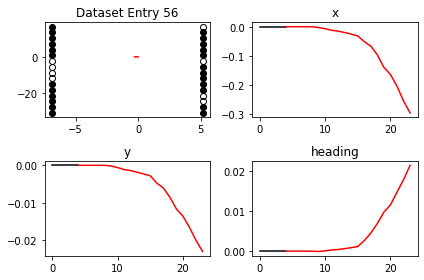

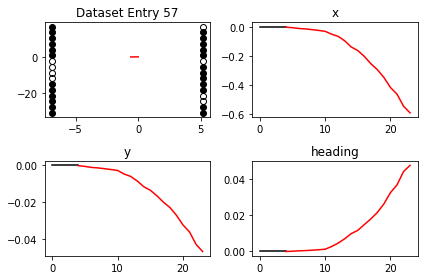

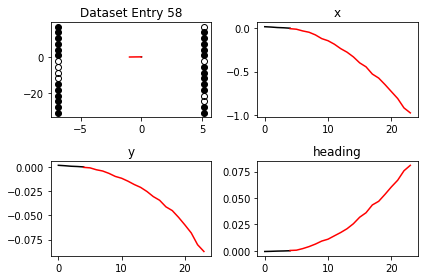

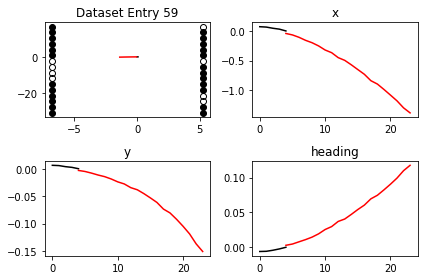

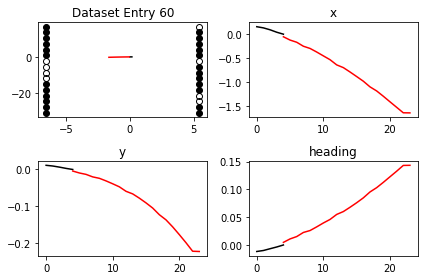

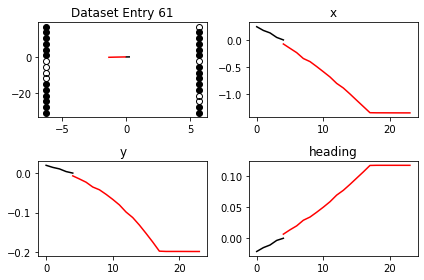

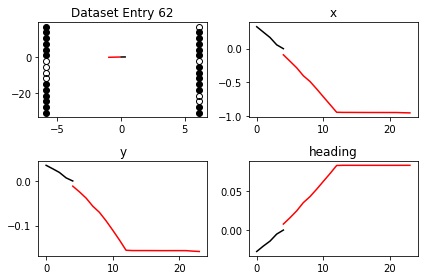

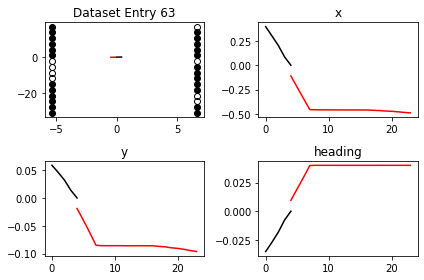

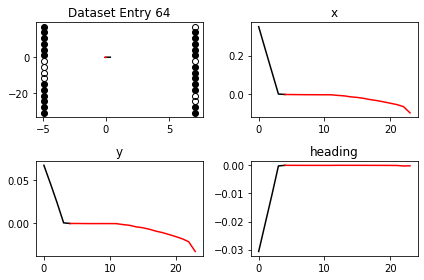

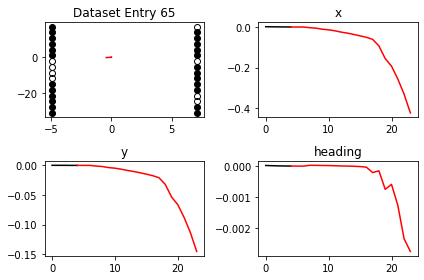

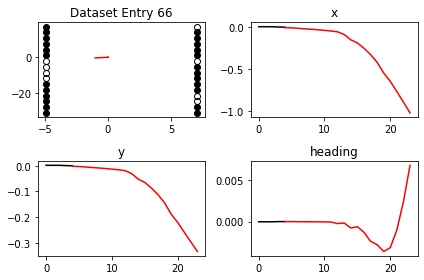

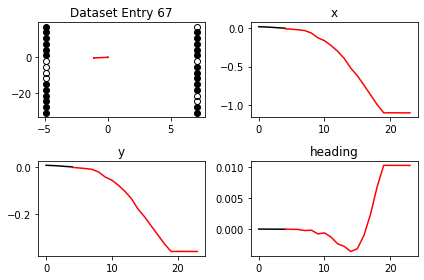

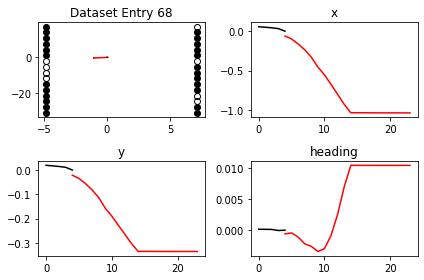

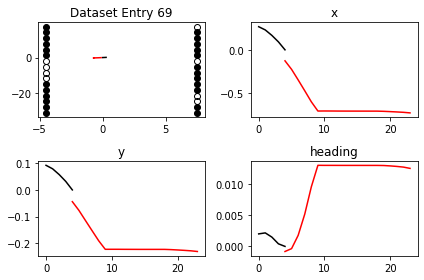

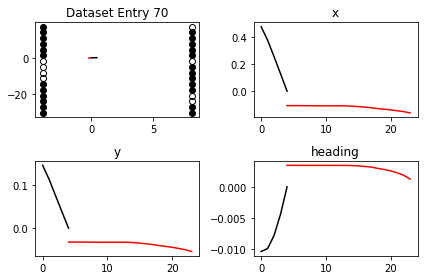

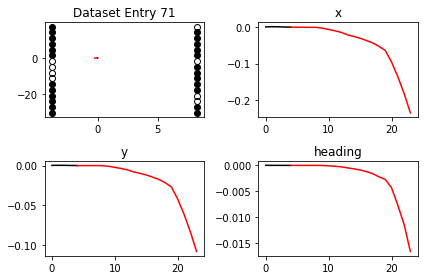

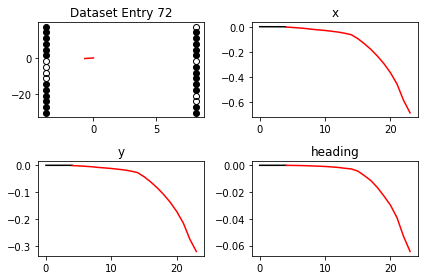

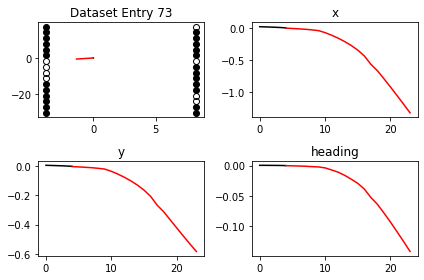

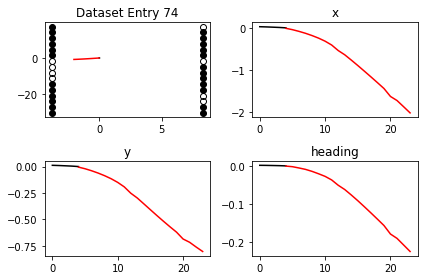

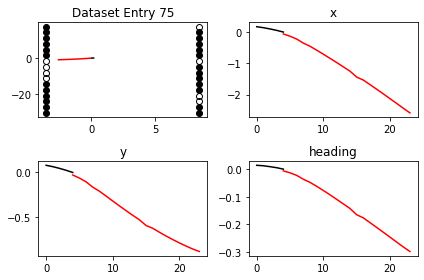

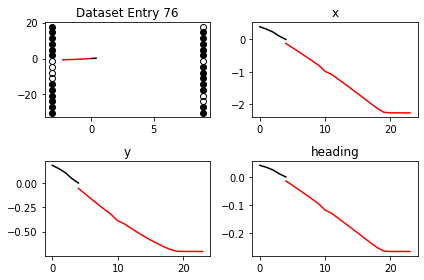

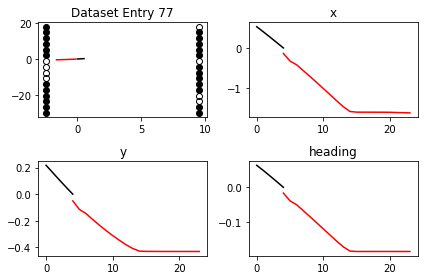

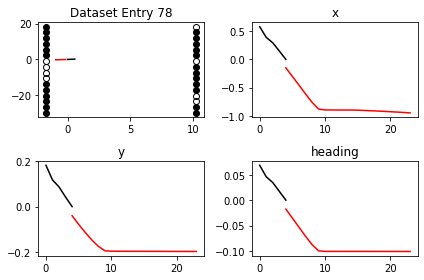

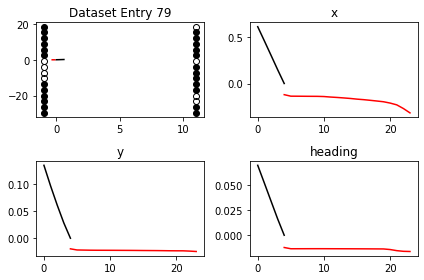

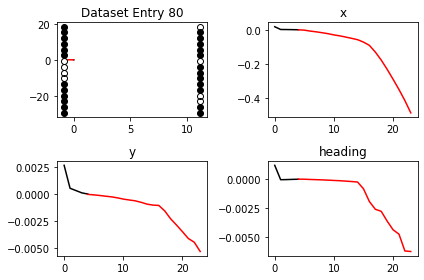

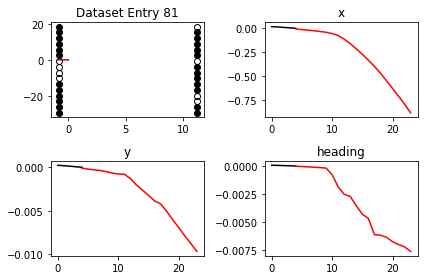

In [15]:
ego_trans = True
features, labels, goal_snpts = get_ego_trajectory_prediction_snippets(ego_trajectory, start_ind, switch_ind, end_ind, goal_ind, \
                                                          goals, ego_frame=ego_trans)

# print(goal_snpts)    

np.set_printoptions(precision=3)
print('Feature Example\n', features[0])
print('Label Example\n', labels[0])

Nhist = 5
Npred = 20

for i in range(0, len(features)):
    plt.figure()
    plt.subplot(221)
    plt.plot(features[i][:,0], features[i][:,1], 'k')
    plt.plot(labels[i][:,0], labels[i][:,1], 'r')
    
    for goal in goal_snpts[i]:
        if goal[2] > 0:
            plt.plot(goal[0], goal[1], 'ko', fillstyle='none')
        else:
            plt.plot(goal[0], goal[1], 'ko')
    plt.title('Dataset Entry %d' % i)
    
    plt.subplot(222)
    
    plt.plot(range(Nhist), features[i][:,0], 'k')
    plt.plot(range(Nhist-1, Nhist+Npred-1), labels[i][:,0], 'r')
    plt.title('x')
    
    plt.subplot(223)
    plt.plot(range(Nhist), features[i][:,1], 'k')
    plt.plot(range(Nhist-1, Nhist+Npred-1), labels[i][:,1], 'r')
    plt.title('y')
    
    plt.subplot(224)
    plt.plot(range(Nhist), features[i][:,2], 'k')
    plt.plot(range(Nhist-1, Nhist+Npred-1), labels[i][:,2], 'r')
    plt.title('heading')
    
    plt.tight_layout()